# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [2]:
import math
import numpy as np

class LinearModel(object):
    def __init__(self, learning_rate, batch_size, alpha=0.0, n_epochs = 100):
        self._w = None
        self._n_epochs = n_epochs
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._alpha = alpha
        self.history = []
            
    def gradient(self, X, y):
        raise NotImplementedError
        
    def predict(self, X):
        raise NotImplementedError        
            
    def fit(self, X, y):
        X_ = X.copy()
        X = np.hstack((np.ones((X.shape[0], 1)), X)) 
        self._w = np.random.randn(X.shape[1], 1)
        batch_size = self._batch_size if self._batch_size is not None else X.shape[0]
        
        for i in range(self._n_epochs):
            for j in range(int(X.shape[0] / batch_size)):
                learning_rate = self._learning_rate if isinstance(self._learning_rate, float) \
                                else self._learning_rate(i * (X.shape[0] / batch_size) + j)
                sample = np.random.choice(X.shape[0], batch_size, replace=False)
                self._w -= learning_rate * self.gradient(X[sample,:], y[sample])
            self.history.append(mse(self.predict(X_), y))


                
class LinearRegression(LinearModel):
    def gradient(self, X, y):
        gradient = np.zeros((X.shape[1], 1))
        for xi, yi in zip(X, y):
            gradient += np.reshape((np.dot(np.transpose(self._w), xi) - yi) * xi, (X.shape[1], 1))
        return gradient * (2.0 / X.shape[0])

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(np.transpose(self._w), np.transpose(X)).flatten()

class RidgeRegression(LinearModel):
    def gradient(self, X, y):
        gradient = np.zeros((X.shape[1], 1))
        for xi, yi in zip(X, y):
            gradient += np.reshape((np.dot(np.transpose(self._w), xi) - yi) * xi, (X.shape[1], 1))
        gradient *= (2.0 / X.shape[0])
        return gradient + 2.0 * self._alpha * self._w
    
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(np.transpose(self._w), np.transpose(X)).flatten()

In [3]:
def mse(y_true, y_pred):
    return ((y_pred - y_true)**2).mean()

In [4]:
linreg = LinearRegression(n_epochs=50, learning_rate=0.0001, batch_size=1)

In [5]:
X_train, X_test = X[ : 800, :], X[800 : , :]
y_train, y_test = Y[ : 800], Y[800 :]

In [6]:
linreg.fit(X_train, y_train)

In [7]:
linreg_predictions = linreg.predict(X_test)

In [8]:
mse(linreg_predictions, y_test)

100.75337657023671

### Кривая обучения

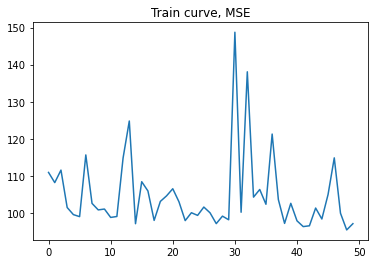

In [9]:
plt.plot(range(len(linreg.history)), linreg.history)
plt.title('Train curve, MSE')
plt.show()

### График среднеквадратичной ошибки в зависимости от параметра регуляризации

In [11]:
mse_list = []
for alpha in range(10):
    ridgereg = RidgeRegression(n_epochs=50, learning_rate=0.0001, batch_size=1, alpha=alpha)
    ridgereg.fit(X_train, y_train)
    mse_list.append(mse(ridgereg.predict(X_test), y_test))

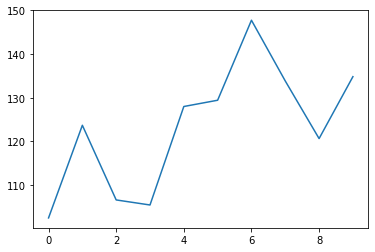

In [12]:
plt.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], mse_list)

In [20]:
alpha = 0.1
mse_val_list = []
mse_train_list = []
best = [10000, 0]
for i in range(5):
    X_train_cv = np.vstack((X[j::5, :] for j in range(5) if j != i))
    X_val = X[i::5, :]
    y_train_cv = np.hstack((Y[j::5] for j in range(5) if j != i))
    y_val = Y[i::5]
    
    ridgereg = RidgeRegression(n_epochs=50, learning_rate=0.0001, batch_size=1, alpha=alpha)
    ridgereg.fit(X_train, y_train)
    y_pred = ridgereg.predict(X_val)
    
    mse_val_list.append(mse(y_val, y_pred))
    mse_train_list.append(mse(y_train_cv, ridgereg.predict(X_train_cv)))
    if mse(y_val, y_pred) < best[0]:
        best[0] = mse(y_val, y_pred)
        best[1] = alpha
    alpha += 1


/var/folders/zj/3n_jg8g55b78my0mk2snjhk80000gn/T/ipykernel_7381/97228523.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_train_cv = np.vstack((X[j::5, :] for j in range(5) if j != i))
/var/folders/zj/3n_jg8g55b78my0mk2snjhk80000gn/T/ipykernel_7381/97228523.py:8: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_train_cv = np.hstack((Y[j::5] for j in range(5) if j != i))


### Валидационная кривая

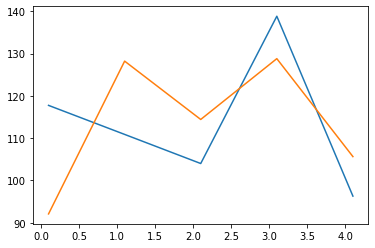

In [21]:
plt.plot([0.1, 1.1, 2.1, 3.1, 4.1], mse_val_list)
plt.plot([0.1, 1.1, 2.1, 3.1, 4.1], mse_train_list)
plt.show()

### Оптимальное значение alpha

In [24]:
print(f'Оптитмальное значение alpha = {best[1]}')

Оптитмальное значение alpha = 4.1


In [25]:
print(f'При оптитмальноем значении alpha mse = {best[0]}')

При оптитмальноем значении alpha mse = 96.30580294627623
